<a href="https://colab.research.google.com/github/semishen/Chinese-NLP-Practices/blob/main/07_SVM_and_Grid_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# load excel
url = 'https://raw.githubusercontent.com/ywchiu/tibame_tm/master/data/google_comments.xlsx'
google = pd.read_excel(url, index_col=0)
print(google.shape)
google.head()

(500, 3)


,username,score,comment
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...


In [ ]:
# convert stars (str) to status ('bad','soso','good')
def score_to_status(x):
  temp = float(x)
  assert (temp < 6.0 and temp > 0.0), 'something wrong'
  if temp > 3:
    temp = 'good'
  elif temp > 2:
    temp = 'soso'
  else:
    temp = 'bad'  
  return temp

google['tag'] = google['score'].map(score_to_status)
google.head()

,username,score,comment,tag
0,倪依芙,5,起初找不到入口，還以為沒座位，但是原來入口在旁邊樓梯～座位區不大，但是料理很好吃～肉圓的醬微...,good
1,Mimi龍,4,聞名已久，今天特別來現場試試，目前改成點餐機點餐， ⋯⋯更多聞名已久，今天特別來現場試試，目...,good
2,林昌逸,1,非常生氣服務員的態度😠服務很糟糕，麵都還沒吃完，一起身就把麵收走，擺明趕客人😡😡😡,bad
3,林幸蓁,5,內用與外帶有不同的點餐方式內用須至店內使用機台點菜、輸入桌號並付款外帶好像只需在入口處點餐即...,good
4,台灣TAXI市區叫車禮車包車約拍找小鄭,5,乾淨衛生，廁所很大在地下室，有免費飲料可以喝，拉麵愛好吃，麻辣豆腐不錯、肉粽不錯，目前吃過很...,good


In [ ]:
# reconstruct df in only good, bad classes

good_bad_df = google[google['tag'].isin(['good','bad'])]
good_bad_df.shape

(440, 4)

In [ ]:
# jieba word segmentation
import jieba

tags = good_bad_df['tag'].to_numpy()
corpus = []
for comment in good_bad_df['comment']:
  corpus.append(' '.join(jieba.cut(comment)))

corpus[:5]


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.785 seconds.
Prefix dict has been built successfully.


['起初 找 不到 入口 ， 還以 為 沒 座位 ， 但是 原來 入口 在 旁邊 樓梯 ～ 座位 區不大 ， 但是 料理 很 好吃 ～ 肉圓 的 醬 微甜 ， 口感 清爽 ～ 甜不辣 醬汁 看 起來 顏色 差不多 ， 但是 口感 是 鹹 中 有 微微 辣 ， 都 很 不錯 ！ 麻醬 麵 的 麻醬 沒有 吝色 放 ， 所以 吃 起來 麻醬 能 均 勻分 佈 在 麵 上 ， 是 吃過 的 好吃 麻醬 麵 之一 ， 挺 讚 的 喔 ！ 喜番 … 今天 遇到 一位 帥氣 有型 的 國中生 讓 座 ， 真感動 ， 現在 能 遇到 單純 有禮 的 青年 學子 ， 都 是 一種 幸運 ！',
 '聞名 已久 ， 今天 特別 來 現場 試試 ， 目前 改成 點餐 機點餐 ，   ⋯ ⋯ 更多聞名 已久 ， 今天 特別 來 現場 試試 ， 目前 改成 點餐 機點餐 ， 店家 可以 省去 點餐 、 結帳 的 人力 ， 缺點 就是 ， 剛剛點 餐時 ， 我 前面 排 了 5 個 人 ， 點餐 就 花 了 不少 時間 ， 更別 說 人 多 的 時候 會 更 久 。 店家 附免費 飲料 - 檸檬汁 ， 還不錯 ， 好喝 實在 ， 不是 隨便 泡 的 飲料 。 今天 點了 餛飩 湯 麵 ＋ 去 骨油 雞 腿 ， 餛飩 麵 份量 很夠 ， 還好 沒多點 肉圓 ， 不然 有點 吃不完 。 雞腿 也 還不錯 ， 有 嚼 勁 。 雖然 是 凌晨 來 吃 ， 店家 內用 生意 還不錯 ， 外送 單 也 常響 起 。 生意 真的 挺 好 的 。',
 '非常 生氣 服務員 的 態度 😠 服務 很 糟糕 ， 麵 都 還沒 吃 完 ， 一 起身 就 把 麵 收走 ， 擺明 趕 客人 😡 😡 😡',
 '內用 與 外帶 有 不同 的 點餐 方式 內用須 至店 內 使用 機台點 菜 、 輸入 桌號並 付款 外帶 好像 只 需 在 入口 處點餐 即可 ( 沒有 外 帶過 ， 不太 確定 )   ⋯ ⋯ 更多 內用 與 外帶 有 不同 的 點餐 方式 內用須 至店 內 使用 機台點 菜 、 輸入 桌號並 付款 外帶 好像 只 需 在 入口 處點餐 即可 ( 沒有 外 帶過 ， 不太 確定 ) 非常 推薦 麻辣 臭豆腐 ！ 有小份 與 大份 另外 ～ 臭豆腐 雖然 可以 點不辣 ， 但是 仍 有 一些 小辣 ， 若 是

In [ ]:
# build a TF-IDF matrix based on contents
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf

<440x2693 sparse matrix of type '<class 'numpy.float64'>'
	with 6513 stored elements in Compressed Sparse Row format>

In [ ]:
indices = good_bad_df.index.values

In [ ]:
# split data into train, test
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y, train_indices, test_indices = \
  train_test_split(tfidf, tags, indices, test_size=0.2, random_state=42)
print(train_x.shape, test_x.shape)
print(test_indices)


(352, 2693) (88, 2693)
[301  90 390 291 369 328 215  94 498 458 262  87 253 449 384  88 493 227
  84 181  10 207  32 226 123 152  81 255 483  62 345 373 184 425 416  83
 239 119  42 274 427 150 264  91 182  36 212 344  89 429 433  16 174 145
   0  20 318 327  64 341 179 107 326 447 322 484  26 211 492 132  48 439
 436 313 203 143 321  23  53 103 282 135 485  65 159  25  18  76]


In [ ]:
# MultinomialNB
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=0.01)
clf1.fit(train_x, train_y)
prediction_clf1 = clf1.predict(test_x)
print(f'acc:{clf1.score(test_x,test_y)}')

acc:0.8181818181818182


In [ ]:
print(clf1.classes_)

['bad' 'good']


In [ ]:
# analysis feature importance
word_eval_list = []
for word, bad_score, good_score in zip(tfidf_vectorizer.get_feature_names(),
                                       clf1.feature_count_[0], 
                                       clf1.feature_count_[1]):
  temp_dict = {}
  temp_dict['bad_ratio'] = bad_score/(1 + good_score)
  temp_dict['good_ratio'] = good_score/(1 + bad_score)
  temp_dict['bad_score'] = bad_score
  temp_dict['good_score'] = good_score
  temp_dict['word'] = word
  word_eval_list.append(temp_dict)

word_eval_df = pd.DataFrame(word_eval_list)

# 10 important words for bad class
word_eval_df.sort_values('bad_ratio', ascending=False).head(10)

,bad_ratio,good_ratio,bad_score,good_score,word
1247,3.228117,0.129321,6.258093,0.938621,態度
1004,2.808830,0.101876,4.335644,0.543576,客人
1130,2.552051,0.000000,2.552051,0.000000,店員態度
1439,2.548792,0.050667,3.075046,0.206472,普通
1924,2.343325,0.049725,2.784275,0.188173,知道
1974,2.227581,0.000000,2.227581,0.000000,第二次
293,2.202086,0.051669,2.613197,0.186692,不要
2483,2.158271,0.000000,2.158271,0.000000,重點
270,2.059802,0.155664,3.503932,0.701101,不會
2155,2.035631,0.000000,2.035631,0.000000,蟑螂


In [ ]:
# 10 important words for good class
word_eval_df.sort_values('good_ratio', ascending=False).head(10)

,bad_ratio,good_ratio,bad_score,good_score,word
971,0.155759,4.432004,2.732156,16.540930,好吃
12,0.016871,4.281420,0.096038,4.692600,24
1041,0.016871,4.281420,0.096038,4.692600,小時
2189,0.018926,4.264247,0.108378,4.726398,親切
973,0.049346,4.072805,0.313289,5.348771,好喝
2050,0.067243,3.478154,0.393055,4.845260,美味
2053,0.026732,3.343670,0.127515,3.770038,美食
2606,0.073043,3.150396,0.393770,4.390926,飲料
340,0.085690,3.121750,0.482174,4.626977,乾意
302,0.115085,3.112518,0.737442,5.407819,不錯


In [ ]:
# SVM baseline
from sklearn.svm import SVC
clf2 = SVC()
clf2.fit(train_x, train_y)
prediction_clf2 = clf2.predict(test_x)
print(f'acc:{clf2.score(test_x,test_y)}')

acc:0.9204545454545454


In [ ]:
# implement grid search
from sklearn.model_selection import GridSearchCV 
  
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001, 0.0001], 'kernel': ['rbf']},
 ]
  
grid = GridSearchCV(SVC(), param_grid) 
grid.fit(train_x, train_y) 

print("Test set score:{:.2f}".format(grid.score(test_x,test_y))) 
print("Best parameters:{}".format(grid.best_params_)) 
print("Best score on train set:{:.2f}".format(grid.best_score_))

Test set score:0.88
Best parameters:{'C': 1, 'kernel': 'linear'}
Best score on train set:0.86


In [ ]:
# after fine tune, use default SVM
clf2 = SVC()
clf2.fit(train_x, train_y)
prediction_clf2 = clf2.predict(test_x)
print(f'acc:{clf2.score(test_x,test_y)}')


acc:0.9204545454545454


In [ ]:
# compute acc and confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix

clf1_acc = accuracy_score(test_y, prediction_clf1)
clf1_cm = confusion_matrix(test_y, prediction_clf1, labels=["good", "bad"])
print('MultinomialNB')
print('acc: ', clf1_acc)
print('confusion_matrix')
print('good', 'bad')
print(clf1_cm)
print('==========================')

clf2_acc = accuracy_score(test_y, prediction_clf2)
clf2_cm = confusion_matrix(test_y, prediction_clf2, labels=["good", "bad"])
print('SVM')
print('acc: ', clf2_acc)
print('confusion_matrix')
print('good', 'bad')
print(clf2_cm)

MultinomialNB
acc:  0.8181818181818182
confusion_matrix
good bad
[[42  6]
 [10 30]]
SVM
acc:  0.9204545454545454
confusion_matrix
good bad
[[45  3]
 [ 4 36]]


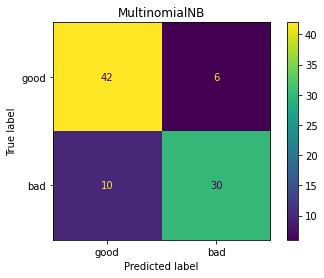

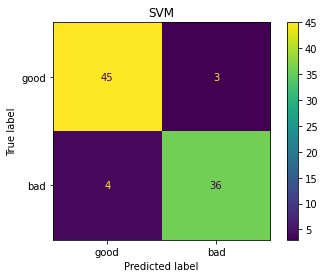

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

nb_cm = plot_confusion_matrix(clf1, test_x, test_y, labels=["good", "bad"])
nb_cm.ax_.set_title('MultinomialNB')

svm_cm = plot_confusion_matrix(clf2, test_x, test_y, labels=["good", "bad"])
svm_cm.ax_.set_title('SVM')

plt.show()
plt.close()

In [ ]:
# analysis errors based on confusion matrix of SVM

error_indices = test_indices[prediction_clf2 != test_y]
for i in error_indices:
  row = google.iloc[i]
  if row['tag'] == 'good':
    predict = 'bad'
  else:
    predict = 'good'
  print(f"predict:{predict} | tag: {row['tag']} | {row['comment']}")

predict:good | tag: bad | 每一段時間會來吃.但是東西品質變的不好了！肉圓的香菜都是爛的［醬汁是冷的］竹筍貢丸湯裡面的竹筍是焦了 ⋯⋯更多每一段時間會來吃.但是東西品質變的不好了！肉圓的香菜都是爛的［醬汁是冷的］竹筍貢丸湯裡面的竹筍是焦了員工素質教育有問題多半是外籍人士現場還可以聽到保險套素質變差了！以後要考慮要不要再來了！
predict:bad | tag: good | 可惜了地點優越，應該衛生要做好，以照顧更多大眾，筷子有味道，湯喝下肚也有種味道。。最近有進步了，改成4顆星
predict:good | tag: bad | 自動點餐機得等一輩子。
predict:good | tag: bad | 不給白飯單買，不然菜單不要寫，食物超激鹹，只有24小時營業是優點，其實7-11比較好吃
predict:bad | tag: good | 提供給深夜下班的人一個能飽餐一頓的地方
predict:bad | tag: good | 招牌意麵敲好粗！強！But... ⋯⋯更多招牌意麵敲好粗！強！But... 肉圓... 你怎麼了... 怎麼那麼大一顆都是粉... 料哪去了？？？（敲碗ing...）
predict:good | tag: bad | 一碗鴨血臭豆腐裡面就有兩隻蟑螂 衛生品質堪憂 不會再去了


In [ ]:
s = '一碗鴨血臭豆腐裡面就有兩隻蟑螂 衛生品質堪憂 不會再去了'
s = [' '.join(jieba.cut(s))]
vec_s = tfidf_vectorizer.transform(s)
clf2.predict(vec_s)

array(['good'], dtype=object)